In [2]:
import numpy as np
import scipy.integrate as integrate
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import array
from scipy.special import spherical_jn
from scipy.integrate import ode
from scipy.optimize import curve_fit

In [3]:
#Calculate the scale factor and its derivative for the SM
df_SM = pd.read_csv('dof_SM_SUSY.csv')
s_df_SM = pd.read_csv('s_dof_SM_SUSY.csv')

#Set constants
h = 0.7
#H0 = 100*h #km s^-1 Mpc^-1
H0 = h/(3.0857*10**17) #s−1
a0 = 1
om_r = 4.15*10**(-5)*h**(-2)
om_m = 1-om_r
om_gamma = 2.4728*10**(-5)*h**(-2)
om_nu = om_r-om_gamma
a_eq = om_r/om_m
F_nu_0 = 0.40523
g0 = df_SM['dof'][0]
gs0 = s_df_SM['s_dof'][0]
g_df_ = df_SM['dof']
gs_df_ = s_df_SM['s_dof']
temperature_ = df_SM['temperature']
T0 = 2.73*8.6173*10**(-11) #MeV
#Mpl = 1.2*10**22 #MeV
Mpl = 2.435*10**21 #MeV, use this one
G = 1/(8*np.pi*Mpl**2)


V_inf = (10**19)**4 #MeV
H_inf = np.sqrt(V_inf/(3*Mpl**2))
mpl = np.sqrt(8*np.pi)*Mpl
delta_prim2 = (16/np.pi)*(H_inf/mpl)**2
P_t = 2*V_inf/(3*np.pi**2*Mpl**4)

In [4]:
#Remove duplicates of temperature and corresponding g and gs (they are next to each other)
print(len(temperature_))
print(len(np.unique(temperature_)))

#temperature_[np.where(temperature_==0.0001)]       
print(temperature_[np.where([temperature_==0.0001])[1]])
print(temperature_[np.where([temperature_==1.0])[1]])
print(temperature_[np.where([temperature_==1000000.0])[1]])

7580
7577
199    0.0001
200    0.0001
Name: temperature, dtype: float64
1199    1.0
1200    1.0
Name: temperature, dtype: float64
6079    1000000.0
6080    1000000.0
Name: temperature, dtype: float64


In [7]:
index = [200,1200,6080]
temperature1 = np.delete(np.array(temperature_),index)
g1 = np.delete(np.array(g_df_),index)
gs1 = np.delete(np.array(gs_df_),index)
print(temperature1[0])
extra_temperatures = np.linspace(T0, temperature1[0],30)[0:-1]
print(T0)
print(extra_temperatures)
temperature = np.append(extra_temperatures, temperature1)
g0_ar = np.full(len(extra_temperatures), g0)
gs0_ar = np.full(len(extra_temperatures), gs0)
g_new = np.append(g0_ar, g1)
gs_new = np.append(gs0_ar, gs1)

1e-09
2.3525229e-10
[2.35252290e-10 2.61622901e-10 2.87993511e-10 3.14364122e-10
 3.40734733e-10 3.67105343e-10 3.93475954e-10 4.19846565e-10
 4.46217176e-10 4.72587786e-10 4.98958397e-10 5.25329008e-10
 5.51699618e-10 5.78070229e-10 6.04440840e-10 6.30811450e-10
 6.57182061e-10 6.83552672e-10 7.09923282e-10 7.36293893e-10
 7.62664504e-10 7.89035114e-10 8.15405725e-10 8.41776336e-10
 8.68146947e-10 8.94517557e-10 9.20888168e-10 9.47258779e-10
 9.73629389e-10]


In [8]:
#Compute all k's
kc0 = 2*np.pi*a0*1.65*2*np.pi*10**(-7)*(T0/(10**3))*(gs0/100)**(-1/3)*(g0/100)**(1/2)
f_0 = 1.65*2*np.pi*10**(-7)*(temperature/(10**3))*(gs_new/100)**(-1/3)*(g_new/100)**(1/2)
k = f_0*2*np.pi*a0
print(k)

[8.70611408e-19 9.68202614e-19 1.06579382e-18 ... 6.49479811e+00
 6.53986312e+00 6.58524082e+00]


In [9]:
#k_eq
T_eq =  ((gs0/gs0)**(1/3))*T0*a0/a_eq #MeV
g_eq = g0
gs_eq = gs0
k_eq = 2*np.pi*a0*1.65*2*np.pi*10**(-7)*(T_eq/(10**3))*(gs_eq/100)**(-1/3)*(g_eq/100)**(1/2)
print(T_eq)
print(k_eq)

2.777442388673855e-06
1.0278637583519936e-14


Text(0, 0.5, 'a')

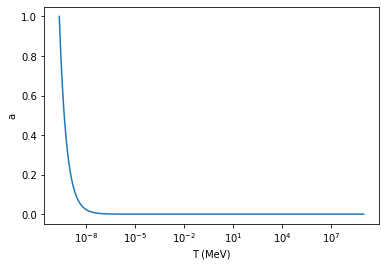

In [10]:
#Relate T to a:
a_T = ((gs0/gs_new)**(1/3))*T0*a0/temperature

plt.plot(temperature, a_T)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('T (MeV)')
plt.ylabel('a')

In [11]:
#Make an array where a, g, gs are reversed
length = len(a_T)-1
print(length)
a_T_res = np.zeros(len(a_T))
g_res = np.zeros(len(a_T))
gs_res = np.zeros(len(a_T))
for i in np.arange(0,len(a_T)):
    a_T_res[i] = a_T[length-i]
    g_res[i] = g_new[length-i]
    gs_res[i] = gs_new[length-i]
    
print(a_T_res[0])

7105
7.429704223977818e-20


In [12]:
#Calculate a, tau, and a'
tau_and_a = np.zeros((len(a_T_res),2))
tau_and_a[0,0] = 0
tau_and_a[0,1] = 0

for i in np.arange(1,len(tau_and_a)):
    tau_and_a[i,0] = a_T_res[i]
    tau_and_a[i,1] = (tau_and_a[i,0]-tau_and_a[i-1,0])/(H0*a0**2*np.sqrt((g_res[i]/g0)*(gs_res[i]/gs0)**(-4/3)*om_r+om_m*a_T_res[i]/a0)) + tau_and_a[i-1,1]
    

dadtau = np.zeros(np.size(tau_and_a[:,0]))
for i in range(np.size(tau_and_a[:,0])):
    dadtau[i] = (tau_and_a[i,0] - tau_and_a[i-1,0])/(tau_and_a[i,1]-tau_and_a[i-1,1])
    


In [13]:
a = tau_and_a[:,0]
tau = tau_and_a[:,1]
aprime = dadtau
kc = k
g = g_new
gs = gs_new

In [14]:
#Matter radiation equality
T_eq =  ((gs0/gs0)**(1/3))*T0*a0/a_eq #MeV
g_eq = g0
gs_eq = gs0
k_eq = 2*np.pi*a0*1.65*2*np.pi*10**(-7)*(T_eq/(10**3))*(gs_eq/100)**(-1/3)*(g_eq/100)**(1/2)
print(k_eq)

1.0278637583519936e-14


In [15]:
#Neutrino decoupling
T_dec =  2 #MeV
print('T_dec', temperature[1247], 'MeV')
gs_dec = gs[1247]
a_dec = ((gs0/gs_dec)**(1/3))*T0*a0/T_dec
print(a_dec)
print('a_dec', a[5858])
print('tau_dec', tau[5858])
tau_dec = tau[5858]

#tau_dec
value=tau[tau>=tau_dec][0]
print(value)
np.where([tau==value])[1][0]
print(tau[np.where([tau==value])[1][0]])
#The index is:
print(np.where([tau==value])[1][0])

T_dec 2.000000000000001 MeV
8.541563015992666e-11
a_dec 8.541563015992662e-11
tau_dec 4970515352.194978
4970515352.194978
4970515352.194978
5858


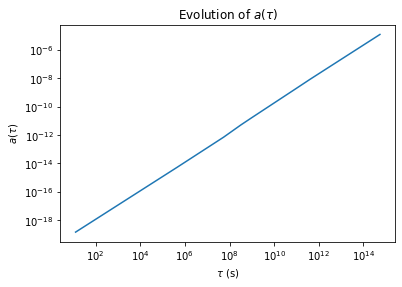

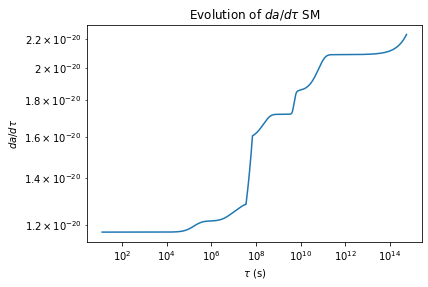

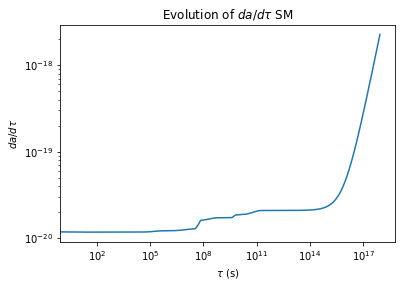

In [19]:
plt.plot(tau[100:-200], a[100:-200])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$a(\tau)$')
plt.title(r'Evolution of $a(\tau)$')
plt.show()

plt.plot(tau[100:-200], aprime[100:-200])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$da/d\tau$')
plt.title(r'Evolution of $da/d\tau$ SM')
plt.savefig('dadtau_SM_zoom.png', bbox_inches='tight')
plt.show()

plt.plot(tau, aprime)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$da/d\tau$')
plt.title(r'Evolution of $da/d\tau$ SM')
plt.savefig('dadtau_SM_full.png', bbox_inches='tight')
plt.show()

In [29]:
#Divide k, g, gs etc in a matter part and radiation part

kc_list = kc[kc<=0.01]
kc_rad = kc_list[kc_list>=k_eq]
kc_matter = kc_list[kc_list<k_eq]
kc_matter_IDE = kc_matter[kc_matter>2*10**(-18)]
kc_matter_after_neutrino = kc_matter[kc_matter<5*10**(-18)]
kc_IDE = np.append(kc_matter, kc_rad)

#Get corresponding a, aprime


a_res = np.zeros(len(a))
time_res = np.zeros(len(tau))
aprime_res = np.zeros(len(aprime))
for i in np.arange(0,len(a)):
    a_res[i] = a[len(a)-1-i]
    time_res[i] = tau[len(tau)-1-i]
    aprime_res[i] = aprime[len(aprime)-1-i]


a_list = a_res[kc<=0.01]
a_rad = a_list[kc_list>=k_eq]
a_matter = a_list[kc_list<k_eq]
a_matter_IDE = a_matter[kc_matter>5*10**(-18)]
a_matter_after_neutrino = a_matter[kc_matter<5*10**(-18)]
a_IDE = np.append(a_matter_IDE, a_rad)

aprime_list = aprime_res[kc<=0.01]
aprime_rad = aprime_list[kc_list>=k_eq]

In [36]:
"""Calculate chi prime for radiation """
solution_Chiprime_rad = np.zeros((len(kc_rad), 2)) #contains for every k; k, chi'(u_hc)

#Calculate chi(u), chi'(u)
def Bessel(x):
    return spherical_jn(2, x)
    
# Define the second-order ODE
def odefunc(t, Y, p):
    y, v = Y
    dydt = v
    dvdt = -2*p*v - y
    return [dydt, dvdt]


def odefuncIntegral(t, Y, p, o, b):
    y, v = Y
    dydt = v
    dvdt = -2*p*v - y - 24*b*p**2*o
    return [dydt, dvdt]


WKB_Chi_Prime_0 = np.zeros(np.size(kc_rad))

F_nu = F_nu_0/(1+a/a_eq)
U_Neutrino = np.where([tau==tau_dec])[1][0] #gives the index of tau = tau_dec
solution_match = np.empty((len(kc_rad), 3)) #contains for every k; k, A, delta

for loop in range(0,len(kc_rad)):
    print(kc_rad[loop])
    u1 = kc_rad[loop]*tau
    u = u1[u1<=2000]

    aprime_over_a = 1/kc_rad[loop]*(aprime/a)
    solution = []
    # Initial conditions
    chi_u_begin = 1
    dchi_du_begin = 0

    # Create an ODE solver
    solver_chi = ode(odefunc)
    solver_chi.set_integrator('dop853',nsteps=100000)  # You can choose a different method if needed

    # Set initial conditions
    solver_chi.set_initial_value([chi_u_begin, dchi_du_begin], t=0)
    
    # Solve the ODE
    q = 1
    solution.append([u[0], chi_u_begin, dchi_du_begin])
    while solver_chi.successful() and solver_chi.t < u[-1] and q<len(u):
        solver_chi.set_f_params(aprime_over_a[q]) 
        solver_chi.integrate(u[q])
        solution.append([solver_chi.t, *solver_chi.y]) #contains time, chi, deriv of chi

        if not solver_chi.successful():
            print('error1', q)
        q+=1

    # Extract the results
    solution = np.array(solution)
    print('First Solution done')
    
    """Perform the IDE"""
    
    #calculate the integral
    U_List = solution[:,0]
    Chi_Prime_List = solution[:,2]
    U_Size = np.size(solution[:,0])
    Integrant = np.zeros([U_Size,U_Size])

    Integral = np.zeros(U_Size)
    for i in range(U_Neutrino,U_Size):
        for j in range(U_Neutrino,i): 
            Integrant[i,j] = (U_List[j]-U_List[j-1])*Chi_Prime_List[j]*Bessel(U_List[i]-U_List[j])/((U_List[i]-U_List[j])**2)
        #print(i,U_Size)
    Integral = np.array(np.diag(np.cumsum(Integrant,axis = 1)))
    print('Integral Done')
    

    solution_Int = []

    # Create an ODE solver
    solver_chi_Int = ode(odefuncIntegral)
    solver_chi_Int.set_integrator('dop853')

    # Set initial conditions
    solver_chi_Int.set_initial_value([chi_u_begin, dchi_du_begin], t=0)
    
    # Solve the ODE
    q = 1
    solution_Int.append([u[0], chi_u_begin, dchi_du_begin, a[0]])
    while solver_chi_Int.successful() and solver_chi_Int.t < u[-1] and q<len(u):
        solver_chi_Int.set_f_params(aprime_over_a[q], Integral[q], F_nu[q])
        solver_chi_Int.integrate(u[q])
        solution_Int.append([solver_chi_Int.t, *solver_chi_Int.y, a[q]]) #contains time, chi, deriv of chi, a
        if not solver_chi_Int.successful():
            print('error Int', q)
        q+=1

    # Extract the results
    solution_Int = np.array(solution_Int)

    #Match to WKB solution
    def WKB(x, a, b):
        return a*np.sin(x+b)
    a_u_latest = solution_Int[:,3][1000:]
    xdata = solution_Int[:,0][1000:] 
    ydata = solution_Int[:,1][1000:]*a_u_latest 
    initial_guess = [1,0.1]
    plt.show()
    popt, pcov = curve_fit(WKB, xdata, ydata, p0 = initial_guess)

    #Use a WKB approximation to find chi'
    tau_0 = tau[-1]
    A = popt[0]
    delta = popt[1]
    da_du0 = 1/kc_rad[loop]*aprime[-1]
    chi_prime_0 = A*np.cos(kc_rad[loop]*tau_0+delta)/a0 - 1/a0**2*da_du0*A*np.sin(kc_rad[loop]*tau_0+delta)
    solution_Chiprime_rad[loop,0], solution_Chiprime_rad[loop,1] = kc_rad[loop], chi_prime_0

"""    

"""  
#Write the rest
ChiPrime_Rad_SM_panda = pd.DataFrame(list(zip(np.transpose(solution_Chiprime_rad[:,0]), np.transpose(solution_Chiprime_rad[:,1]))), columns=['kc', "chi_prime"])
ChiPrime_Rad_SM_panda.to_csv('ChiPrime_Rad_SM_SUSY.csv', index=False)

1.0854933758740704e-14


C:\Users\Annet\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


First Solution done
Integral Done
1.1501455559457934e-14
First Solution done
Integral Done
1.218648431453277e-14
First Solution done
Integral Done
1.2912313505070205e-14
First Solution done
Integral Done
1.3681373212320984e-14
First Solution done
Integral Done
1.4496238253610782e-14
First Solution done
Integral Done
1.535963680284685e-14
First Solution done
Integral Done
1.6274459524463493e-14
First Solution done
Integral Done
1.724376925138686e-14
First Solution done
Integral Done
1.827081123942129e-14
First Solution done
Integral Done
1.9359024032388683e-14
First Solution done
Integral Done
2.0512050974397443e-14
First Solution done
Integral Done
2.1733752407784182e-14
First Solution done
Integral Done
2.3028218597567102e-14
First Solution done
Integral Done
2.43997834256823e-14
First Solution done
Integral Done
2.585303890085096e-14
First Solution done
Integral Done
2.7392850532656846e-14
First Solution done
Integral Done
2.9024373621306805e-14
First Solution done
Integral Done
3.07

In [30]:
"""Calculate chi prime for matter """
solution_Chiprime_matter = np.zeros((len(kc_matter_IDE), 2)) #contains for every k; k, chi'(u_hc)

#Calculate chi(u), chi'(u)
def Bessel(x):
    return spherical_jn(2, x)
    
# Define the second-order ODE
def odefunc(t, Y, p):
    y, v = Y
    dydt = v
    dvdt = -2*p*v - y
    return [dydt, dvdt]


def odefuncIntegral(t, Y, p, o, b):
    y, v = Y
    dydt = v
    dvdt = -2*p*v - y - 24*b*p**2*o
    return [dydt, dvdt]

F_nu = F_nu_0/(1+a/a_eq)
U_Neutrino = np.where([tau==tau_dec])[1][0] #gives the index of tau = tau_dec


for loop in range(0,len(kc_matter_IDE)):
    print(kc_matter_IDE[loop])
    u = kc_matter_IDE[loop]*tau

    aprime_over_a = 1/kc_matter_IDE[loop]*(aprime/a)
    solution = []
    # Initial conditions
    chi_u_begin = 1
    dchi_du_begin = 0

    # Create an ODE solver
    solver_chi = ode(odefunc)
    solver_chi.set_integrator('dop853')  # You can choose a different method if needed

    # Set initial conditions
    solver_chi.set_initial_value([chi_u_begin, dchi_du_begin], t=0)
    
    # Solve the ODE
    
    q = 1
    solution.append([u[0], chi_u_begin, dchi_du_begin])
    while solver_chi.successful() and solver_chi.t < u[-1]: #and q<=len(u):
        solver_chi.set_f_params(aprime_over_a[q])
        solver_chi.integrate(u[q])
        solution.append([solver_chi.t, *solver_chi.y]) #contains time, chi, deriv of chi
        if not solver_chi.successful():
            print('error', q)
        q+=1

    # Extract the results
    solution = np.array(solution)
    
    #Now add the integral
    U_List = solution[:,0]
    Chi_Prime_List = solution[:,2]
    U_Size = np.size(solution[:,0])
    Integrant = np.zeros([U_Size,U_Size])

    Integral = np.zeros(U_Size)
    for i in range(U_Neutrino,U_Size):
        for j in range(U_Neutrino,i): 
            Integrant[i,j] = (U_List[j]-U_List[j-1])*Chi_Prime_List[j]*Bessel(U_List[i]-U_List[j])/((U_List[i]-U_List[j])**2)
        #print(i,U_Size)
    Integral = np.array(np.diag(np.cumsum(Integrant,axis = 1)))
    print('Integral Done')
    
    solution_Int = []

    # Create an ODE solver
    solver_chi_Int = ode(odefuncIntegral)
    solver_chi_Int.set_integrator('dop853')

    # Set initial conditions
    solver_chi_Int.set_initial_value([chi_u_begin, dchi_du_begin], t=0)
    
    # Solve the ODE
    q = 1
    solution_Int.append([u[0], chi_u_begin, dchi_du_begin])
    while solver_chi_Int.successful() and solver_chi_Int.t < u[-1]: #and q<=len(u):
        solver_chi_Int.set_f_params(aprime_over_a[q], Integral[q], F_nu[q])
        solver_chi_Int.integrate(u[q])
        solution_Int.append([solver_chi_Int.t, *solver_chi_Int.y]) #contains time, chi, deriv of chi
        if not solver_chi_Int.successful():
            print('error', q)
        q+=1

    # Extract the results
    solution_Int = np.array(solution_Int)
    solution_Chiprime_matter[loop,0], solution_Chiprime_matter[loop,1] = kc_matter_IDE[loop], solution_Int[-1,2]
ChiPrime_Matter_SM_panda = pd.DataFrame(list(zip(np.transpose(solution_Chiprime_matter[:,0]), np.transpose(solution_Chiprime_matter[:,1]))), columns=['kc', "chi_prime"])
ChiPrime_Matter_SM_panda.to_csv('ChiPrime_Matter_SM_SUSY.csv', index=False)

2.041705870965509e-18


C:\Users\Annet\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


Integral Done
2.1392970761838045e-18
Integral Done
2.2368882814020994e-18
Integral Done
2.3344794866203946e-18
Integral Done
2.4320706918386902e-18
Integral Done
2.529661897056986e-18
Integral Done
2.627253102275281e-18
Integral Done
2.724844307493575e-18
Integral Done
2.8224355127118704e-18
Integral Done
2.920026717930166e-18
Integral Done
3.0176179231484616e-18
Integral Done
3.1152091283667553e-18
Integral Done
3.2128003335850517e-18
Integral Done
3.3103915388033473e-18
Integral Done
3.407982744021641e-18
Integral Done
3.505573949239937e-18
Integral Done
3.603165154458232e-18
Integral Done
3.700756359676528e-18
Integral Done
3.921174071921635e-18
Integral Done
4.154719902624039e-18
Integral Done
4.402175764872602e-18
Integral Done
4.6643701426399865e-18
Integral Done
4.942180864552777e-18
Integral Done
5.2365380428679586e-18
Integral Done
5.548427187495225e-18
Integral Done
5.878892505491232e-18
Integral Done
6.2290403970721146e-18
Integral Done
6.600043159849263e-18
Integral Done
6.